In [458]:
%matplotlib inline
# %matplotlib notebook

In [459]:
from skimage.io import collection, imread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import stats as stat

import os
import re
import glob

from datetime import datetime
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

import yfinance as yf
from afinn import Afinn

import time

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\kaloy\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# How is the public opinion about a company correlated to it's market value?

A company's market value is variable and depends on a lot of factors. The price is a reflection of the company's perceived value - what the public is willing to pay for a piece of the company. It can and will rise and fall, based on a variety of factors in the global landscape and within the company itself. One of which is becoming more influential than ever - people's opinion on social media.

To analyze this correlation we'll look at two datasets. The first one contains over 3 million unique tweets with their information such as tweet id, author of the tweet, post date, the text body of the tweet, and the number of comments, likes, and retweets of tweets matched with the related company.

The second one will just have daily stock price records (from the Forbes2000) for us to make a reference with.

### 1. Data Acquisition 

So first let's read the tweets dataset into pandas and inspect a small sample from the two dataframes.

In [460]:
tweets = pd.read_csv('./top-companies-tweets/Tweet.csv')
tweets.sample(5)

tweet_id          writer   post_date  \
1537010   808372153305337856      dmackdaddy  1481565914   
418960    622207242016698368         JETWAKE  1437180741   
1016001   729745307739824128          Zaarch  1462819814   
3125007  1105074973956337667          tslaq9  1552305379   
3455831  1158482540396781568  Income_Analyst  1565038735   

                                                      body  comment_num  \
1537010  #Tesla will start cracking down on Supercharge...            0   
418960   $GOOG + $159 PER SHARE in the last 9 days! A g...            0   
1016001  $SYNC ... Puts that deal in context. $ATT $GOO...            0   
3125007  I feel $tsla is a great short at $287 pre mark...            0   
3455831  $SPY $DIA $AAPL $AMZN The Dow closed down 767 ...            0   

         retweet_num  like_num  
1537010            1         0  
418960             0         0  
1016001            0         0  
3125007            0         1  
3455831            0         0

In [461]:
tweets_company = pd.read_csv('./top-companies-tweets/Company_Tweet.csv')
tweets_company.sample(5)

tweet_id ticker_symbol
3399909   741261376019156992          TSLA
1927411   754173913027018757         GOOGL
1756216  1018961390999044096          GOOG
2225455   647515783074066432          AMZN
4167700  1142676483493679104          TSLA

So next up let's read the datasets for each of the stocks, which we are monitoring. We will save them in a dictionary with the key, being the company's tick name and the value - it's stock prices over time dataset.

In [462]:
stocks_df = {}
for name in glob.glob('./stocks/*'):
    stocks_df[name.split('\\')[-1].split('.')[0]] = pd.read_csv(name)

stock_keys = list(stocks_df.keys())
for key in stock_keys:
    print(key)
    print(stocks_df[key].head(3))

AAPL
         Date       Low      Open     Volume      High     Close  \
0  12-12-1980  0.128348  0.128348  469033600  0.128906  0.128348   
1  15-12-1980  0.121652  0.122210  175884800  0.122210  0.121652   
2  16-12-1980  0.112723  0.113281  105728000  0.113281  0.112723   

   Adjusted Close  
0        0.100751  
1        0.095495  
2        0.088485  
AMZN
         Date       Low      Open    Volume      High     Close  \
0  15-05-1997  1.927083  2.437500  72156000  2.500000  1.958333   
1  16-05-1997  1.708333  1.968750  14700000  1.979167  1.729167   
2  19-05-1997  1.625000  1.760417   6106800  1.770833  1.708333   

   Adjusted Close  
0        1.958333  
1        1.729167  
2        1.708333  
GOOG
         Date        Low       Open    Volume       High      Close  \
0  19-08-2004  47.800831  49.813290  44871361  51.835709  49.982655   
1  20-08-2004  50.062355  50.316402  22942874  54.336334  53.952770   
2  23-08-2004  54.321388  55.168217  18342897  56.528118  54.495735   

Let's take a look at all the unique stocks we have data on.

In [463]:
stock_keys

['AAPL', 'AMZN', 'GOOG', 'MSFT', 'TSLA']

And now let's do the same for the tweets.

In [464]:
tweets_company.ticker_symbol.unique().tolist()

['AAPL', 'GOOG', 'GOOGL', 'AMZN', 'MSFT', 'TSLA']

As we can see twitter dataset we have contains data about both GOOG and GOOGL (with stockholder's voting rights) stocks, but the datasets on the stock prices don't. That's why we have to get GOOGL stock data from somewhere else. The *yfinance* library contains historical market data.

In [465]:
googl_stock = yf.Ticker('GOOGL')

googl_stock = googl_stock.history(period="max")

# Reset the index and combine the dataframe with our existing dataset.
googl_stock = googl_stock.reset_index()
googl_stock.sample(5)

Date         Open         High          Low        Close   Volume  \
3621 2019-01-08  1086.000000  1093.349976  1068.349976  1085.369995  1770700   
2821 2015-11-02   734.530029   748.179993   731.450012   747.739990  1995700   
3409 2018-03-06  1102.099976  1105.630005  1094.500000  1100.900024  1169100   
1323 2009-11-18   288.613617   289.679688   286.321320   288.613617  3096101   
3534 2018-08-31  1252.209961  1252.550049  1225.750000  1231.800049  2115400   

      Dividends  Stock Splits  
3621          0           0.0  
2821          0           0.0  
3409          0           0.0  
1323          0           0.0  
3534          0           0.0

We would like the columns here to perfectly match our other dataframes' columns, so that we can combine them all easily.

In [466]:
column_names = list(stocks_df[stock_keys[0]].columns)
column_names

['Date', 'Low', 'Open', 'Volume', 'High', 'Close', 'Adjusted Close']

We don't have the Adjusted Close column in our yfinance dataset. But won't be using it, so we can simply remove it.

In [467]:
column_names = column_names[:-1]

googl_stock = googl_stock[column_names]
googl_stock.sample(5)

Date          Low         Open   Volume         High        Close
1243 2009-07-28   218.268265   220.720718  5059935   221.626633   220.145142
1898 2012-03-02   310.470459   311.311310  3143453   312.312317   310.935944
3816 2019-10-16  1238.530029  1241.810059  1149300  1254.189941  1243.000000
1819 2011-11-07   296.411407   296.956970  6708085   304.694702   304.469482
3971 2020-05-29  1415.979980  1420.430054  1852200  1436.729980  1433.520020

### 2. Data Tidying and Cleaning

First let's combine the two tables from the twitter dataset, convert the dates to a datetime object and rename the column.

In [468]:
tweets = pd.merge(tweets, tweets_company, on = "tweet_id")

In [469]:
tweets["date"] = pd.to_datetime(tweets.post_date, unit='s')
tweets = tweets.drop(columns="post_date")
tweets.sample(5)

tweet_id           writer  \
1398615  762026475897749504  stockmarketbul1   
477566   622141962766823424          QP_AAPL   
650307   647392005845192706    AppleNewsAAPL   
1862866  826872581567426564         TribalSU   
2504280  944242575858458624      sjgoldstein   

                                                      body  comment_num  \
1398615  AAPL Broadcom Ltd. BidRead More --> http://dlv...            0   
477566   $AAPL News: "Google Now, Maps And Apple Music ...            0   
650307   $AAPL Teardowns of iPhone 6s, Plus reveal heav...            0   
1862866  AT&T Deal Is Just The Beginning https://seekin...            0   
2504280  Forget Wearables -- Smart Speakers May Be More...            0   

         retweet_num  like_num ticker_symbol                date  
1398615            0         1          AAPL 2016-08-06 20:44:04  
477566             0         0          GOOG 2015-07-17 20:32:57  
650307             0         0          AAPL 2015-09-25 12:47:36  
1862866            0         0          AMZN 2017-02-01 19:19:20  
2504280            1         0          AMZN 2017-12-22 16:25:47

We will see what timeframe does our dataset cover, by getting the data of the earliest and latest tweets.

In [470]:
tweets.date.min(), tweets.date.max()

(Timestamp('2015-01-01 00:00:57'), Timestamp('2019-12-31 23:55:53'))

Before we start working with the stocks dataset, we want to combine the individual dataframes, that we have. We got the GOOGL stock data from a different data source so let's check its dtypes compared to the other ones.

In [471]:
googl_stock.dtypes, stocks_df['AAPL'].dtypes

(Date      datetime64[ns]
 Low              float64
 Open             float64
 Volume             int64
 High             float64
 Close            float64
 dtype: object, Date               object
 Low               float64
 Open              float64
 Volume              int64
 High              float64
 Close             float64
 Adjusted Close    float64
 dtype: object)

The GOOGL dataset has different data type for the "Date" column compared to the AAPL one. To combat this, we will convert it temporarily to a similarly formated string. And let's also remove the "Adjusted Close" from all the other datasets, because we are not going to use it.

In [472]:
for key in stock_keys:
    stocks_df[key] = stocks_df[key].drop(columns=["Adjusted Close"])

In [473]:
def date_to_string(date):
    return date.strftime('%d-%m-%Y')

googl_stock.Date = googl_stock.Date.apply(date_to_string)

Now we can finally add the GOOGL market history dataset to our list and combine the list into one large dataframe, which will be easier to work with.

In [474]:
stocks_df['GOOGL'] = googl_stock

stocks = pd.concat(stocks_df)
stocks.sample(10)

Date          Low         Open     Volume         High  \
MSFT  708    29-12-1988     0.361111     0.361111   38275200     0.371528   
GOOGL 2090   06-12-2012   342.597595   344.139130    2921675   348.153168   
      1576   19-11-2010   295.465454   298.798798    4590405   299.244232   
GOOG  3698   30-04-2019  1175.000000  1185.000000    6207000  1192.810059   
AAPL  10162  05-04-2021   123.070000   123.870003   88651200   126.160004   
AMZN  2376   24-10-2006    32.860001    32.869999   23155300    38.000000   
GOOG  3065   20-10-2016   796.030029   803.299988    1757500   803.969971   
MSFT  1631   24-08-1992     2.148438     2.175781   42800000     2.187500   
AAPL  9109   26-01-2017    30.400000    30.417500  105350400    30.610001   
      9      26-12-1980     0.158482     0.158482   55574400     0.159040   

                   Close  
MSFT  708       0.369792  
GOOGL 2090    345.910919  
      1576    295.710724  
GOOG  3698   1188.479980  
AAPL  10162   125.900002  
AMZN  2376     33.630001  
GOOG  3065    796.969971  
MSFT  1631      2.156250  
AAPL  9109     30.485001  
      9         0.158482

We saw earlier, that our twitter dataset has data from 01.01.2015 to 31.12.2019, so basically from 2015 to the beginning of 2020. Knowing this we can filter out the stock prices to be only in this period of time. But first we have to covert the "Date" column to datetime.

In [475]:
def string_to_date(date_string):
    return datetime.strptime(date_string, "%d-%m-%Y")
stocks.Date = pd.to_datetime(stocks.Date.apply(string_to_date))

In [476]:
stocks = stocks[(stocks.Date >= tweets.date.min()) & (stocks.Date < tweets.date.max())]
stocks.sample(10)

Date          Low         Open     Volume         High  \
GOOG  3194 2017-04-27   870.380005   873.599976    2026800   875.400024   
AAPL  8865 2016-02-08    23.260000    23.282499  216085600    23.924999   
MSFT  8369 2019-05-28   126.050003   126.980003   23128400   128.000000   
      7563 2016-03-14    52.630001    52.709999   24083600    53.590000   
AAPL  9182 2017-05-11    38.077499    38.112499  109020400    38.517502   
AMZN  4810 2016-06-27   682.119995   692.010010    5568000   696.820007   
GOOGL 2787 2015-09-15   653.340027   656.710022    1777300   668.849976   
      2620 2015-01-15   502.010010   508.890015    2553400   509.750000   
GOOG  3670 2019-03-20  1196.170044  1197.349976    2227400  1227.140015   
MSFT  7553 2016-02-29    50.660000    51.349998   31654000    51.650002   

                  Close  
GOOG  3194   874.250000  
AAPL  8865    23.752501  
MSFT  8369   126.160004  
      7563    53.169998  
AAPL  9182    38.487499  
AMZN  4810   691.359985  
GOOGL 2787   665.070007  
      2620   504.010010  
GOOG  3670  1223.969971  
MSFT  7553    50.880001

As we can see we don't have data for every day, because the stock market functions only on workdays, unlike twitter.  We will find a way to work around this later.

Now lets strip the data down to just two columns 
   * the value, which we will calculate by getting the mean of the Open and Close prices
   * the volume, which we have already

In [477]:
stocks["Value"] = (stocks.Open + stocks.Close) / 2
stocks = stocks.drop(columns=['Low', 'Open', 'High', 'Close'])
stocks.sample(10)

Date    Volume        Value
GOOG  2977 2016-06-16   1982500   712.634979
      2743 2015-07-14   3244100   553.929993
GOOGL 3193 2017-04-26   1323300   890.265015
MSFT  8241 2018-11-19  44773900   106.445000
AMZN  5088 2017-08-03   3255800   993.194977
AAPL  9201 2017-06-08  85003200    38.780001
MSFT  8111 2018-05-16  17384700    97.255001
GOOG  3492 2018-07-03    679000  1119.354980
      2619 2015-01-14   2235721   496.397141
      2656 2015-03-10   1792307   558.097748

It is a little inconvenient to have the stock name as an index instead of it being a regular column. We will fix that and also change the column names to match the twitter dataset.

In [478]:
stocks = stocks.reset_index(level=0)

In [479]:
stocks.columns = ["ticker_symbol", "date", "volume", "value"]
stocks.sample(10)
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7548 entries, 8589 to 2393
Data columns (total 4 columns):
ticker_symbol    7548 non-null object
date             7548 non-null datetime64[ns]
volume           7548 non-null int64
value            7548 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 294.8+ KB


 So next up lets take a look at the datatypes and null values for the twitter dataset.

In [480]:
tweets.info(null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4336445 entries, 0 to 4336444
Data columns (total 8 columns):
tweet_id         4336445 non-null int64
writer           4280526 non-null object
body             4336445 non-null object
comment_num      4336445 non-null int64
retweet_num      4336445 non-null int64
like_num         4336445 non-null int64
ticker_symbol    4336445 non-null object
date             4336445 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(3)
memory usage: 297.8+ MB


Everything looks good, except the ticker_symbol which should be a category. Also the writer column has quite a few missing records, but we won't be using it for our model and analysis, so we can discard it altogether.

In [481]:
tweets.ticker_symbol = tweets.ticker_symbol.astype('category')
tweets = tweets.drop(columns=["writer"])
tweets.head(7)

tweet_id                                               body  \
0  550441509175443456  lx21 made $10,008  on $AAPL -Check it out! htt...   
1  550441672312512512  Insanity of today weirdo massive selling. $aap...   
2  550441732014223360  S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...   
3  550442977802207232  $GM $TSLA: Volkswagen Pushes 2014 Record Recal...   
4  550443807834402816  Swing Trading: Up To 8.91% Return In 14 Days h...   
5  550443807834402816  Swing Trading: Up To 8.91% Return In 14 Days h...   
6  550443808606126081  Swing Trading: Up To 8.91% Return In 14 Days h...   

   comment_num  retweet_num  like_num ticker_symbol                date  
0            0            0         1          AAPL 2015-01-01 00:00:57  
1            0            0         0          AAPL 2015-01-01 00:01:36  
2            0            0         0          AMZN 2015-01-01 00:01:50  
3            0            0         1          TSLA 2015-01-01 00:06:47  
4            0            0         1          AAPL 2015-01-01 00:10:05  
5            0            0         1          TSLA 2015-01-01 00:10:05  
6            0            0         1          AAPL 2015-01-01 00:10:05

As we can see there seem to be a lot of duplicate bodies in our dataset. We want to remove them and this is exactly what the following code does. 

In [482]:
tweets = tweets.drop_duplicates(subset=["body"])

### 3. Text Preparation and Exploration

Before we start working with the text, we have to prepare it and take a quick look at some statistics about it. First let's convert all the tweets' bodies into lowercase.

In [483]:
tweets.body = tweets.body.str.lower()

Before we separate the tweets into words, we want to remove any urls from them.

In [484]:
url_regex = r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)'
def remove_url_from_string(str):
    return re.sub(url_regex, '', str)
tweets.body = tweets.body.apply(remove_url_from_string)

NLTK provides a small corpus of stop words that we will load into a list, based on which we'll later filter them out from the tweets.

In [485]:
stopwords = nltk.corpus.stopwords.words("english")
stopwords.append("")

To properly analyze the text for starters we would like to split it into single words and remove all the stopwords from it. Later on we would like to apply some sort of sentiment analysis, which works on whole texts, not lists of words, so we will save the "tokenized" version into a new variable, which we can work with.

In [486]:
def string_into_words(string): 
    return [w for w in re.split("\W+", string) if w not in stopwords]

tokenized_tweets = tweets.body.apply(string_into_words).copy()
tokenized_tweets.sample(5)

3613598    [skylum, releases, airmagic, ai, powered, dron...
4305160    [industry, giants, partnering, simplify, futur...
2960450    [tsla, guy, nc, pays, m3, full, tesla, delayed...
2851549    [wow, tsla, googl, calls, absolutely, ripping,...
1250449    [scanning, bezos, india, article, amazon, 21, ...
Name: body, dtype: object

Now we can look at the frequency distribution of the words (how many times is each word appears in the tweets). Just because the dataset is too large to analyze every observation. To combat this we will take a smaller sample of the data.

In [487]:
tweets_sample = tokenized_tweets.sample(10000, random_state=10)
tweets_sample.head(3)

1362011    [mobileye, drops, 10, ends, tesla, relationshi...
3439937    [50, dma, resistance, today, kiq, vips, ntes, ...
2974882    [active, traders, try, one, free, trading, gui...
Name: body, dtype: object

In [488]:
all_words = tweets_sample.sum()

In [489]:
fd = nltk.FreqDist(all_words)

In [490]:
common_words = np.array(fd.most_common(30))
common_words

array([['aapl', '4063'],
       ['tsla', '3131'],
       ['amzn', '2239'],
       ['apple', '1487'],
       ['read', '1257'],
       ['goog', '1116'],
       ['msft', '1059'],
       ['googl', '985'],
       ['fb', '806'],
       ['stock', '708'],
       ['tesla', '707'],
       ['stocks', '560'],
       ['google', '545'],
       ['nflx', '536'],
       ['microsoft', '510'],
       ['new', '497'],
       ['inc', '491'],
       ['amazon', '486'],
       ['spy', '473'],
       ['like', '459'],
       ['1', '458'],
       ['market', '390'],
       ['today', '381'],
       ['3', '378'],
       ['buy', '358'],
       ['iphone', '351'],
       ['get', '350'],
       ['day', '336'],
       ['trading', '335'],
       ['2', '328']], dtype='<U9')

We can plot this data with a bar chart.

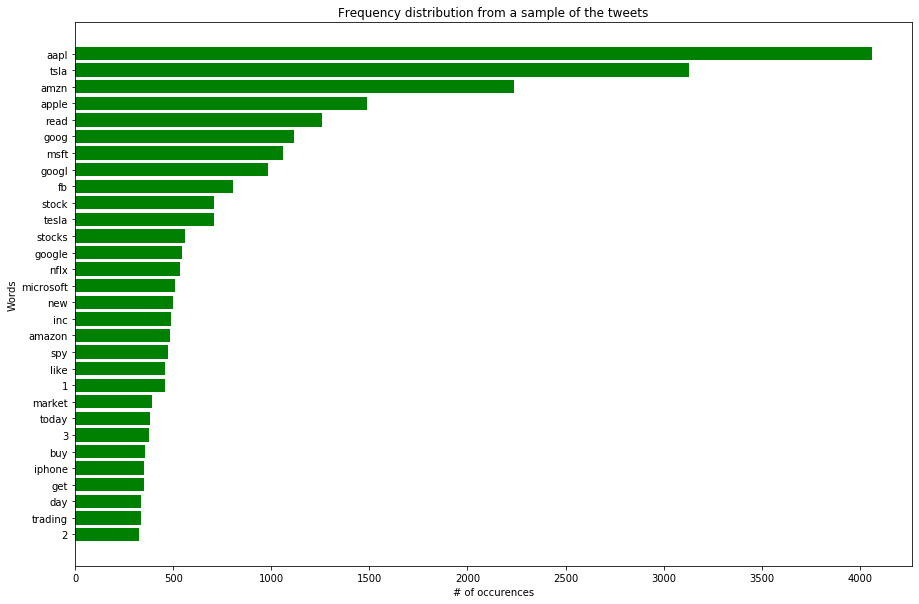

In [491]:
common_words = np.flip(common_words, axis=0)
bar_words = common_words[:, 0]
bar_occu = common_words[:, 1].astype(int)
bar_x = [i for i, _ in enumerate(bar_words)]

plt.figure(figsize=(15, 10))
plt.barh(bar_x, bar_occu, color='green')
plt.xlabel("# of occurences")
plt.ylabel("Words")
plt.title("Frequency distribution from a sample of the tweets")

plt.yticks(bar_x, bar_words)

plt.show()

The first 30 words consist mainly of companies' names and stock ticks as we can expect. But at the bottom there we can see words like \"like\" and "buy". This is very important, because they express some sort of sentiment.

### 4. Hypotheses

There are two main ways that social media could affect the market.
   1. The overall **amount of tweets** about a company raises the interest in its stocks, which results into more transactions being made (positions being closed and opened). The metric which tracks how much a stock is being traded is called **"Trading Volume"**. We can look for a correlation between the traded volume of a stock and how much people "talked" about it the previous day. 
       * The **null hypothesis** here is: There is *no correlation* between the amount of tweets about a company with the volume of its stock traded.
       * And the **alternate hypothesis**: The *is a correlation* between the amount of tweets about a company with the volume of its stock traded.


   2. Another important detail is what actually we're the people saying. In other words we would like to know if the general public opinion correlates in some way with the price's fluctuation. And what I mean by public opinion is whether the majority of the statements about a company made *online* are **positive or negative**. We will look at the correlation of the **average sentiment** of all tweets about a company and its **stock price** the following day.
       * **Null hypothesis**: There is *no correlation* between the ratio of positive/negative tweets about a company with the price of its stock on the same day.
       * And the **alternate hypothesis**: There *is a correlation* between the ratio of positive/negative tweets about a company with the price of its stock on the same day.

To test the our hypotheses we can use a correlation coefficient. The most common of these are the *Pearson correlation coefficient* and the *Spearman's rank correlation*. The first one is sensitive only to a linear relationship between two variables, which is not what we are looking for. The *Spearman's rank correlation coefficient* however is a lot more robust (sensitive to *non-linear relationships*) than Pearson's. That is why we will use it for this project.

If the p-value (*p*) of the Spearman correlation falls below our standard threshold (5% or 0.05), we can safely reject the null-hypothesis and conclude that there is a correlation between the variables, which we will be testing.

### 5. Trading Volume and Amount of tweets

To look at the data for the individual stocks we first have to split the tweets dataset into different parts depending on what company they are about. We can create a function which does this for us, because will have to apply again later.

In [492]:
# Take the tickers which we have by looking at the unique values of the ticker_symbol column
tickers = tweets.ticker_symbol.unique().categories.tolist()

def split_by_ticker(df: pd.DataFrame):
    """  
    Split the dataframe into a list of dataframes based on the ticker_symbol column
    """
    return [df[df.ticker_symbol == ticker] for ticker in tickers]

tweets_by_company = split_by_ticker(tweets)

Now we want to group the tweet data based on the date of the tweet.

In [493]:
amount_tweets_by_date = [t_by_company.groupby('date').size() for t_by_company in tweets_by_company]
amount_tweets_by_date[0].head(5)

date
2015-01-01 00:00:57    1
2015-01-01 00:01:36    1
2015-01-01 00:10:05    3
2015-01-01 00:10:16    1
2015-01-01 00:10:17    3
dtype: int64

As we can see if we just group by the date column it also takes the time of day into account. We don't want that. To group only by the day we have to use a pandas Grouper class.

In [494]:
# The pandas Grouper class allows us to use a "freq" parameter which specifies
# the interval by which we would like to group our datetime objects
amount_tweets_by_date = [t_by_company.groupby(pd.Grouper(key="date", freq="D")).size() for t_by_company in tweets_by_company]
amount_tweets_by_date[0].head(5)

date
2015-01-01    280
2015-01-02    809
2015-01-03    231
2015-01-04    270
2015-01-05    891
Freq: D, dtype: int64

This gives us exactly what we want. We know which dataframe corresponds to which company by its index and the "ticks" list. Now we want to compare this data to the Volume of the given stock, again grouped by day.

Here after we split the data by ticker symbol just like we did for the tweets, we can simply remove all unnecessary columns, because the data is already given to us by date.

In [495]:
stocks_by_company = split_by_ticker(stocks)
stocks_by_company[0].head(6)

ticker_symbol       date     volume     value
8589          AAPL 2015-01-02  212818400  27.59000
8590          AAPL 2015-01-05  257142000  26.81750
8591          AAPL 2015-01-06  263188400  26.60000
8592          AAPL 2015-01-07  160423600  26.86875
8593          AAPL 2015-01-08  237458000  27.64000
8594          AAPL 2015-01-09  214798000  28.08500

Let's get a Series (from the volume column with a date index), which we can plot a lot easier.

In [496]:
volume_stocks_by_date = [stock_by_company.set_index("date")["volume"] for stock_by_company in stocks_by_company]
volume_stocks_by_date[0].head(5)

date
2015-01-02    212818400
2015-01-05    257142000
2015-01-06    263188400
2015-01-07    160423600
2015-01-08    237458000
Name: volume, dtype: int64

Now we can plot the data and take a look at it.

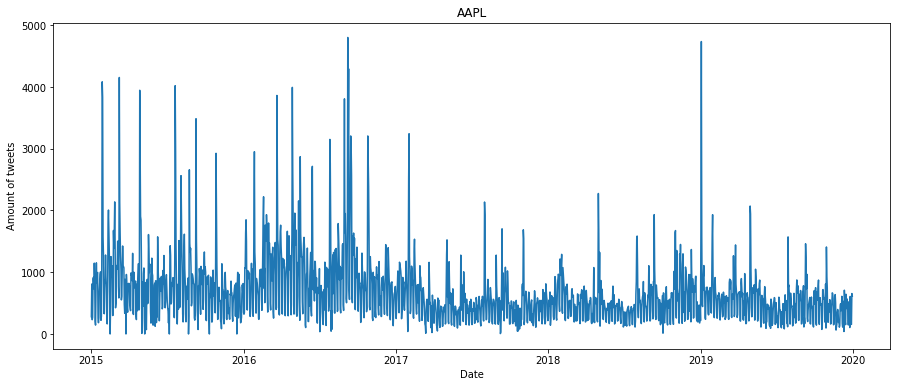

In [497]:
plt.figure(figsize=(15, 6))
plt.plot(amount_tweets_by_date[0])
plt.title(tickers[0])
plt.xlabel("Date")
plt.ylabel("Amount of tweets")
plt.show()

As we can see the data differs a lot from day to day so maybe it would be more useful for us to plot it on a monthly basis.

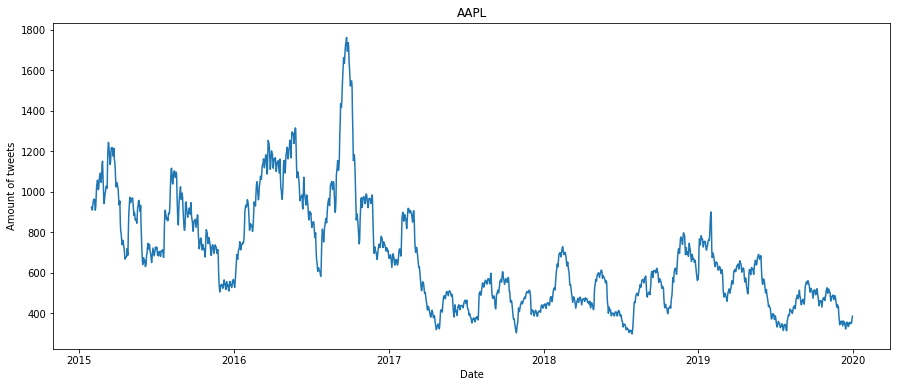

In [498]:
# Make the plot wider, so it is easier to read 
plt.figure(figsize=(15, 6))

# Get the mean of every 30 rows in our dataset and plot this instead of the data for every day.
tweets_by_month = amount_tweets_by_date[0].rolling(30).mean()
plt.plot(tweets_by_month)

plt.title(tickers[0])

plt.xlabel("Date")
plt.ylabel("Amount of tweets")

plt.show()

Now we can see some trends a lot clearer. It's time to plot the traded volume against the tweet amount.

In [582]:
def plot_two_variables_for_company(ticker, var1, var2, ax_label1, ax_label2, adj_limits=False):
    """
    Plot two variables for a stock for every 30 days.
    """
    company_index = tickers.index(ticker)
        
    # Create a pyplot figure and add two axis to it, which share the same x coords.
    fig = plt.figure(figsize=(16, 8))
    ax1 = fig.add_subplot(label=ax_label1)
    ax2 = ax1.twinx()
    
    # Get the mean of every 30 rows in our dataset and plot this instead of the data for every day.
    var1_by_month = var1[company_index].dropna().rolling(30).mean()
    var2_by_month = var2[company_index].dropna().rolling(30).mean()
    
    ax1.plot(var1_by_month, label=ax_label1)
    ax2.plot(var2_by_month, color="Orange", label=ax_label2)
    
    ax1.set_title(tickers[company_index])
    # Major ticks very 3 months.
    fmt_every_three_months = mdates.MonthLocator(interval=3)
    ax1.xaxis.set_major_locator(fmt_every_three_months)
    
    # Format the major ticks to show the month name and year.
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    
    # Minor ticks every month
    fmt_month = mdates.MonthLocator()
    ax1.xaxis.set_minor_locator(fmt_month)
    
    ax1.set_xlabel("Date")
    ax1.set_ylabel(ax_label1)
    ax2.set_ylabel(ax_label2)
    
    # Adjust the axis' limits if explicitly requested
    if(adj_limits):
        ax1.set_ylim(var1[company_index].min(), var1[company_index].max())
        ax2.set_ylim(var2[company_index].min(), var2[company_index].max())
    
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)
    
    # Auto format the xaxis labels so that there is enough room for them to be shown
    fig.autofmt_xdate()
    
    plt.show()

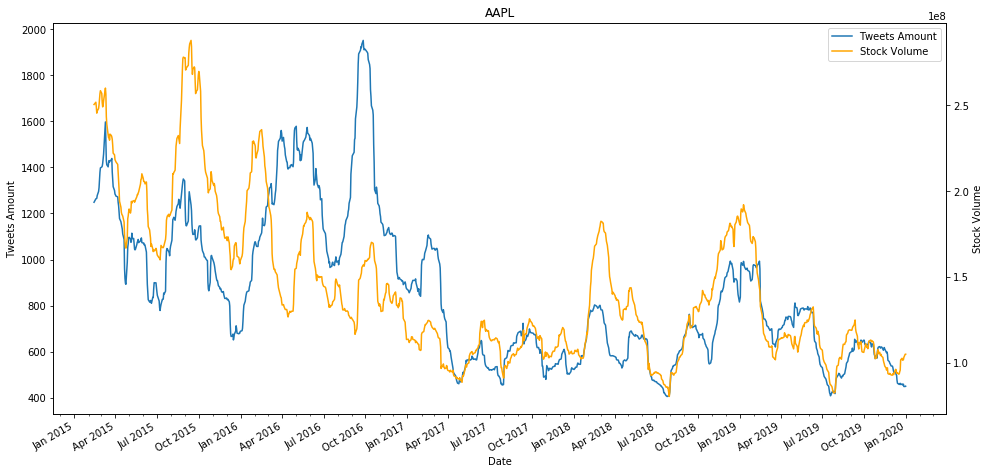

In [583]:
plot_two_variables_for_company('AAPL', amount_tweets_by_date, volume_stocks_by_date, "Tweets Amount", "Stock Volume")

We can see that there clearly is some correlation between the two variables, especially in the second half of the chart.

Now we can calculate the ***Spearman's rank correlation coefficient*** using the `scipy` library and it's `stats` module. But first the two series which we will be comparing must have the same dimensions, so we are going to reindex one of them. This will remove all the twitter data about weekends, because we don't have stock market data about them.

In [501]:
print("AAPL Twitter data length: ", len(amount_tweets_by_date[0]))
print("AAPL Volume stock data length: ", len(amount_tweets_by_date[0].reindex(volume_stocks_by_date[0].index)))
print("AAPL Twitter data length after reindexing: ", len(volume_stocks_by_date[0]))

amount_tweets_by_date = [t.reindex(s.index) for (t, s) in zip(amount_tweets_by_date, volume_stocks_by_date)]

AAPL Twitter data length:  1826
AAPL Volume stock data length:  1258
AAPL Twitter data length after reindexing:  1258


In [502]:
corr, pval = stat.spearmanr(amount_tweets_by_date[0], volume_stocks_by_date[0], nan_policy="omit")
def print_sp_corr(corr, pval):
    print("Spearman correlation: \n\n\tcorrelation coefficient = {0:.5f}\n\tp-value = {1:.5f}\n".format(corr, pval))

print_sp_corr(corr, pval)

Spearman correlation: 

	correlation coefficient = 0.63380
	p-value = 0.00000



As we can see the p-value, which we were using for our test is below 0.05 and actually very close to 0. Let's look at these values for all six different companies.

In [525]:
def calc_spearman(comp_name, var1, var2):
    index = tickers.index(comp_name)
    return stat.spearmanr(var1[index], var2[index], nan_policy="omit")

In [526]:
correlation_results = []
for ticker in tickers:
    print(ticker)
    corr, pval = calc_spearman(ticker, amount_tweets_by_date, volume_stocks_by_date)
    print_sp_corr(corr, pval)
    correlation_results.append([corr, pval])
correlation_results = np.array(correlation_results)

AAPL
Spearman correlation: 

	correlation coefficient = 0.63380
	p-value = 0.00000

AMZN
Spearman correlation: 

	correlation coefficient = 0.43131
	p-value = 0.00000

TSLA
Spearman correlation: 

	correlation coefficient = 0.78763
	p-value = 0.00000

GOOG
Spearman correlation: 

	correlation coefficient = 0.35725
	p-value = 0.00000

MSFT
Spearman correlation: 

	correlation coefficient = 0.09479
	p-value = 0.00076

GOOGL
Spearman correlation: 

	correlation coefficient = 0.45858
	p-value = 0.00000



To get a clearer view let's graph the results.

In [505]:
def display_correlation_results(correlation_results):
    p_values = correlation_results[:, 1]
    correlations = correlation_results[:, 0]

    y_axis = np.arange(len(tickers))

    fig = plt.figure(figsize=(16, 8))
    ax_corr = fig.add_subplot(label="Correlation coefficient")
    ax_p = ax_corr.twiny()

    # Display both variables in one chart by offsetting the bars' position
    ax_corr.barh(y_axis - 0.21, correlations, 0.4, label="Correlation coefficient")
    ax_p.barh(y_axis + 0.21, p_values, 0.4, label="P-value", color="orange")

    for index, value in enumerate(correlations):
        ax_corr.text(value + 0.005, index - 0.21, str(round(value, 3)), color='blue', size="medium", ha="left", va="center")

    for index, value in enumerate(p_values):
        ax_p.text(p_values.min(), index + 0.21, str(value), color='black', size="x-large", ha="left", va="center")


    # Make the scale for the p-value logarithmic, because the values are too small
    ax_p.set_xscale('log')

    # Set proper chart labels
    ax_corr.set_xlabel("Company")
    ax_corr.set_ylabel("Correlation coefficient")
    ax_p.set_xlabel("P-value")

    # Create a legend
    lines, labels = ax_corr.get_legend_handles_labels()
    lines2, labels2 = ax_p.get_legend_handles_labels()
    ax_corr.legend(lines + lines2, labels + labels2, loc=0)

    # Set the x axis ticks
    plt.yticks(ticks=y_axis, labels=tickers)

    plt.show()

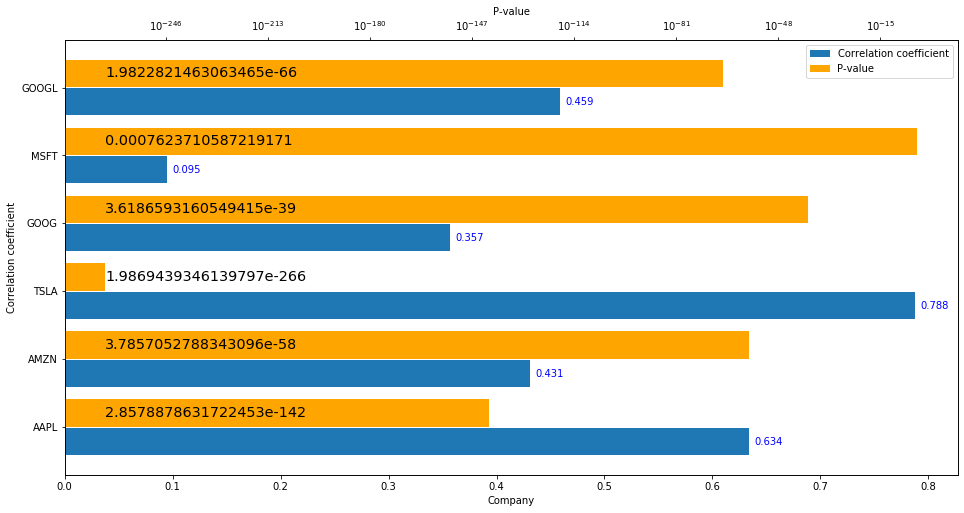

In [528]:
display_correlation_results(correlation_results)

Lets also take a look at the volume/tweet amount data graphed for each company.

AAPL
Spearman correlation: 

	correlation coefficient = 0.63380
	p-value = 0.00000



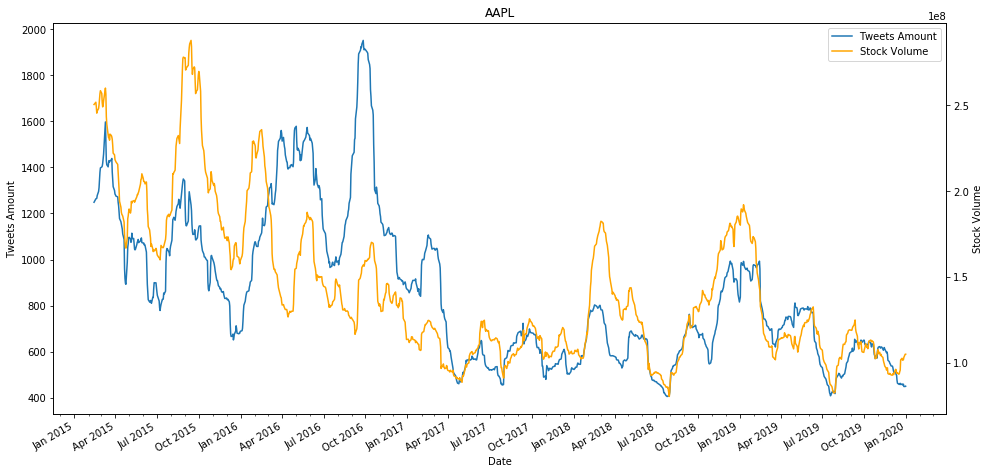

AMZN
Spearman correlation: 

	correlation coefficient = 0.43131
	p-value = 0.00000



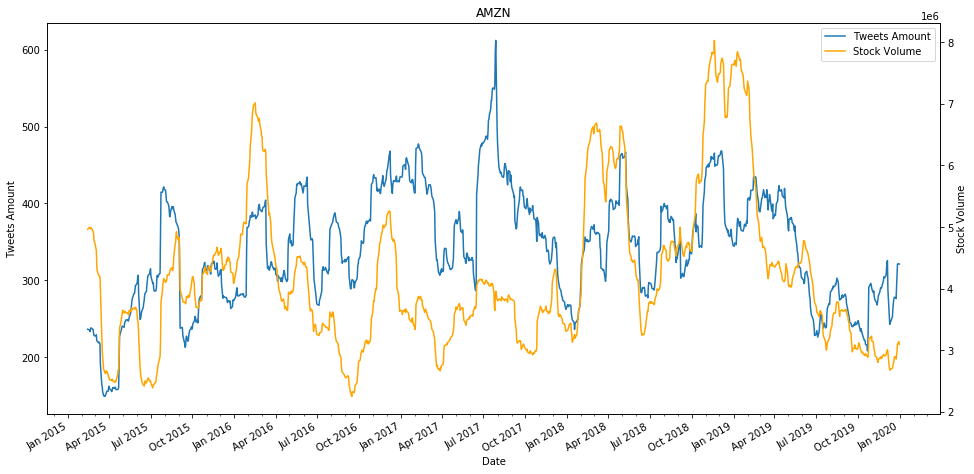

TSLA
Spearman correlation: 

	correlation coefficient = 0.78763
	p-value = 0.00000



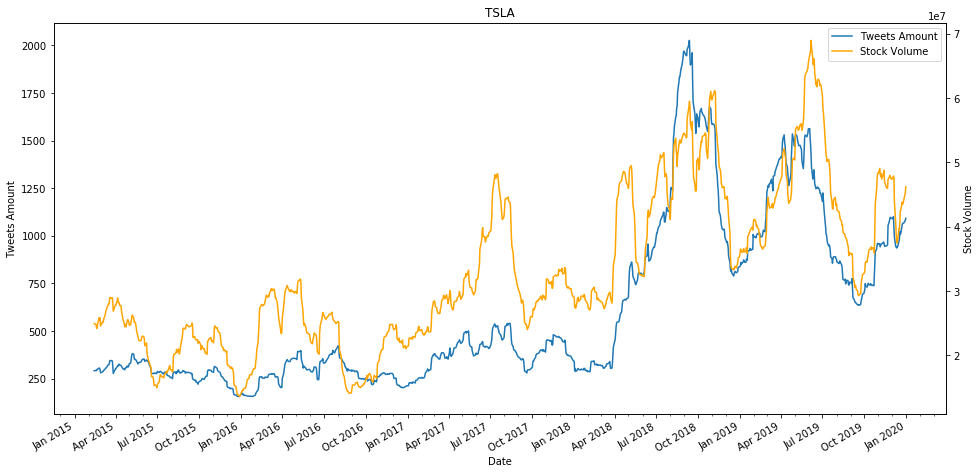

GOOG
Spearman correlation: 

	correlation coefficient = 0.35725
	p-value = 0.00000



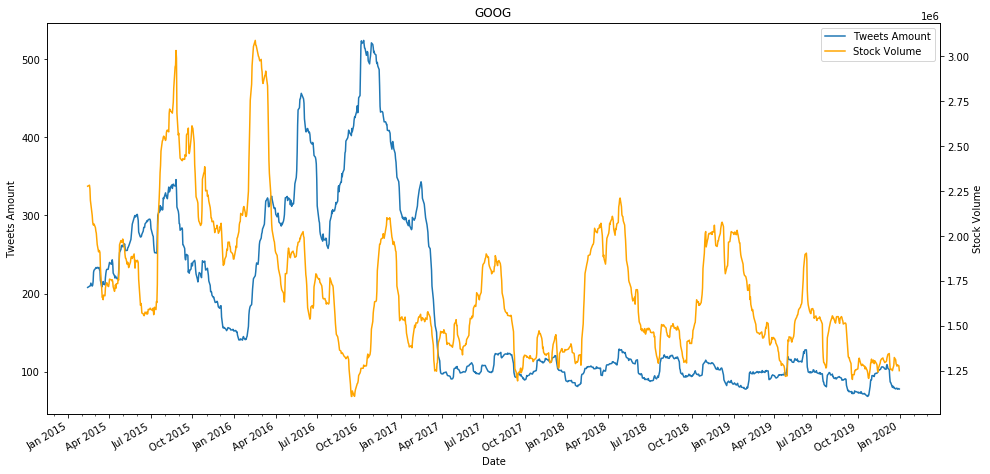

MSFT
Spearman correlation: 

	correlation coefficient = 0.09479
	p-value = 0.00076



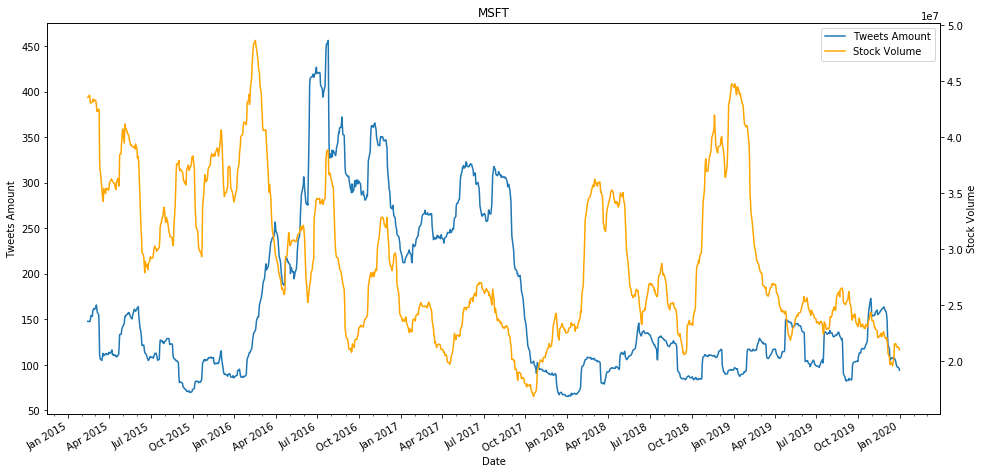

GOOGL
Spearman correlation: 

	correlation coefficient = 0.45858
	p-value = 0.00000



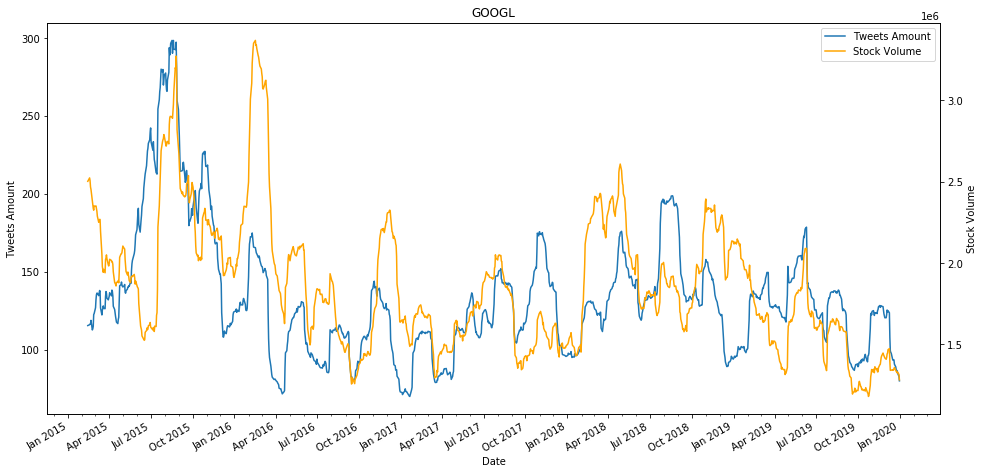

In [527]:
for company_index in range(len(tickers)):
    company = tickers[company_index]
    print(company)
    corr, pval = calc_spearman(company, amount_tweets_by_date, volume_stocks_by_date)
    print_sp_corr(corr, pval)
    plot_two_variables_for_company(company, amount_tweets_by_date, volume_stocks_by_date, "Tweets Amount", "Stock Volume")

Here we can see that the all the p-values satisfy our criteria (to be less than 0.05). This means that we can reject the null hypothesis and say that ***there is a positive correlation*** between the amount of tweets talking about a company on a certain day with the volume of its stock traded.

It is not certain that this is always true as we can see with the MSFT stock. There the p-value is a lot closer to 1 than all the other values and the coefficient is only about 0.09. So the strength of the connection between those variables in the general case is somewhat questionable.

However there is another conclusion which we can make. The correlation depends a lot on which company we are looking at. The AAPL and TSLA stocks have the biggest correlation coefficients, which is hardly a coincidence. Tesla and Apple are maybe the most "hyped" publicly traded companies. Regular ordinary people care about their faith and buy their stocks. But even there Tesla has almost 80% correlation coefficient. This is due to the nature of the company and it's management. The famous Elon Musk is know for making very influential tweets about the stock market and even his own company. 

> In May 2020, Musk tweeted that “Tesla’s stock price is too high imo.” That day Tesla’s stock price closed 10 percent lower than the day before. 
>
>On the evening of July 29, 2019, Musk tweeted about Tesla’s solar roof production, which sent the stock up about 3 percent at market close the following day.
>
>Tesla CEO Elon Musk got into hot water with regulators back in 2018 for infamously tweeting about taking the company private at a nice round stock price of $420.
>
> -- <cite>By Rani Molla for Vox</cite>

The actual CEO of Tesla legitimizes twitter and social media in general as a way to influence a stock's value, even if he does it accidentally. 

Another factor as stated earlier is the hype surrounding those companies. The second biggest coefficient belongs to Apple. This again isn't a surprise. A lot of people use their products and care about the company and of course discuss it's stock price on social media, by which they create more trading interest and intern more trades.

### 5. Stock price and public opinion

The next hypothesis, which we will be testing is whether there are is a correlation between the sentiment of the tweets about a company and its share price.
* **Null hypothesis**: There is *no correlation* between the ratio of positive/negative tweets about a company with the price of its stock on the same day.
* And the **alternate hypothesis**: There *is a correlation* between the ratio of positive/negative tweets about a company with the price of its stock on the same day.

To analyze the sentiment of the tweets we will be using a pretrained sentiment analyzer called *VADER* (**V**alance **A**ware **D**ictionary and s**E**ntiment **R**easoner). It is built-in into NLTK. VADER is best suited for language used in social media (like short sentences with some slang and abbreviations), which is perfect for what we will be using it. Other sentiment analyzers like AFINN look at individual words and assign them a score, which is not what we are looking for. VADER scores the entire text, which makes the algorithm very flexible and sensitive to negations, such as "not" and strong adjectives ("booster" words) such as "remarkably". This is we I choose to use it in this project.

In [508]:
sia = SentimentIntensityAnalyzer()

After we initialize the sentiment analyzer class, we can try it on some basic examples.

In [509]:
sia.polarity_scores("Wow, this course was awesome!")

{'neg': 0.0, 'neu': 0.268, 'pos': 0.732, 'compound': 0.8478}

We get a dictionary of scores. The negative, neutral and positive scores add up to 1 and are related. The compound score is a normalized value from the other three, which ranges between -1 and 1.

I really like where this is going 0.4201
I like where this is going 0.3612
I don't like where this is going -0.2755
I hate where this is going -0.5719


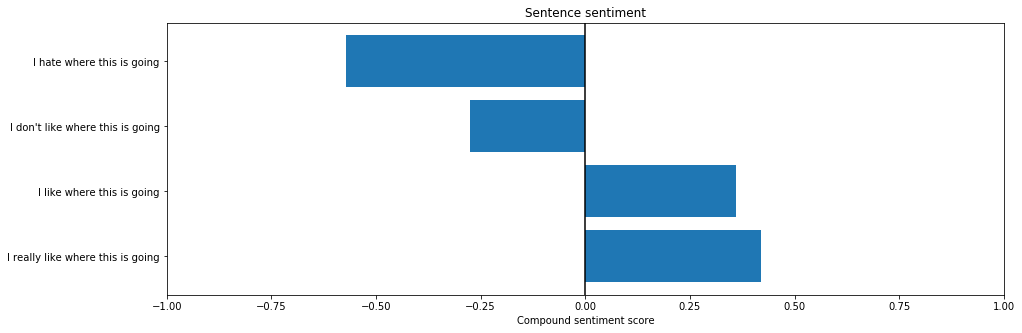

In [510]:
tests = [
    "I really like where this is going",
    "I like where this is going",
    "I don't like where this is going",
    "I hate where this is going"
]
scores = [sia.polarity_scores(test)["compound"] for test in tests]
tests_range = np.arange(len(tests))
for test, score in zip(tests, scores):
    print(test, score)

plt.figure(figsize=(15, 5))
plt.barh(tests_range, scores)
plt.yticks(ticks=tests_range, labels=tests)
plt.axvline(color="black")
plt.xlim(-1, 1)
plt.title("Sentence sentiment")
plt.xlabel("Compound sentiment score")
plt.show()

We can see that the algorithm takes into account modifiers, negations and context. Some sentences while having the same meaning can express stronger opinions. VADER takes this into account by giving us not only a classification, but a compound score based on how positive/negative the text is.

Another important factor to the sentiment analysis algorithms is their speed. We have a really large dataset so if the VADER algorithm is considerably slower we might want to reconsider our decision to use it. So lets do a quick test with different small amounts of tweets.

In [516]:
tweet_amount_tests = [100, 200, 400, 5000]
for tweet_amount in tweet_amount_tests:
    tweets_small_sample = tweets.sample(tweet_amount)
    
    tic = time.perf_counter()
    tweets_small_sample["score"] = tweets_small_sample.body.apply(lambda b: sia.polarity_scores(b)["compound"])
    toc = time.perf_counter()
    print(f"Analyzing {tweet_amount} tweets with VADER took {toc - tic:0.4f} seconds")

    afinn = Afinn()

    tic = time.perf_counter()
    tweets_small_sample["score"] = tweets_small_sample.body.apply(lambda b: afinn.score(b))
    toc = time.perf_counter()
    print(f"Analyzing {tweet_amount} tweets with AFINN took {toc - tic:0.4f} seconds\n")

Analyzing 100 tweets with VADER took 0.0238 seconds
Analyzing 100 tweets with AFINN took 0.0449 seconds

Analyzing 200 tweets with VADER took 0.0422 seconds
Analyzing 200 tweets with AFINN took 0.0947 seconds

Analyzing 400 tweets with VADER took 0.0917 seconds
Analyzing 400 tweets with AFINN took 0.1775 seconds

Analyzing 5000 tweets with VADER took 0.9263 seconds
Analyzing 5000 tweets with AFINN took 2.3399 seconds



As we can see the VADER algorithm is nearly two times faster in all our tests so from now on we will stick with it.

Let's test all the tweets we have and save the results in the `tweets` dataframe.

In [517]:
tic = time.perf_counter()
tweets["score"] = tweets.body.apply(lambda b: sia.polarity_scores(b)["compound"])
tweets.head(20)
toc = time.perf_counter()
print(f"Analyzing all {len(tweets)} tweets took {toc - tic:0.4f} seconds\n")

Analyzing all 3326194 tweets took 649.5773 seconds



Now we can split the tweets dataset by company as we did before and save it into a list. After that we have to group all the data by date and get the mean tweet sentiment score for each date.

In [544]:
score_tweets_by_company = split_by_ticker(tweets)
score_twets_by_date = \
        [t.groupby(pd.Grouper(key="date", freq="D"))["score"].mean() for t in score_tweets_by_company]

Our tweets sentiment data is almost ready to be analyzed. We just have to to remove all the weekends, but for this our stock prices data needs to be ready.

In [545]:
value_stocks_by_date = [stock_by_company.set_index("date")["value"] for stock_by_company in stocks_by_company]
value_stocks_by_date[0].head(6)

date
2015-01-02    27.59000
2015-01-05    26.81750
2015-01-06    26.60000
2015-01-07    26.86875
2015-01-08    27.64000
2015-01-09    28.08500
Name: value, dtype: float64

Instead of reindexing like before we will merge the series into a dataframe, retaining only rows, which were previously in both sets. 

In [568]:
score_twets_by_date = \
    [pd.merge(s, v, how="inner", on="date")["score"] for (s, v) in zip(score_twets_by_date, value_stocks_by_date)]
len(score_twets_by_date[0]), len(value_stocks_by_date[0])

(1258, 1258)

Let's plot the data for one of the companies, so we can take a better look at it.

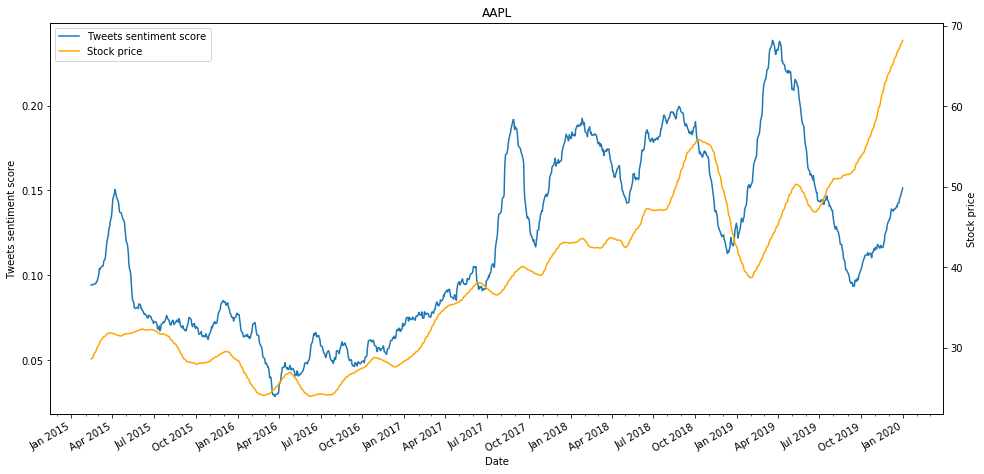

In [584]:
plot_two_variables_for_company('AAPL', score_twets_by_date, value_stocks_by_date, 'Tweets sentiment score', 'Stock price')

We can see that there is some correlation, but the coefficient will help us be sure and possibly discard the null hypothesis.

Now we are completely ready to calculate the Spearman's correlation coefficient between the price of the stock and the average sentiment of the tweets for all the companies.

In [529]:
correlation_results = []
for ticker in tickers:
    print(ticker)
    corr, pval = calc_spearman(ticker, score_twets_by_date, value_stocks_by_date)
    print_sp_corr(corr, pval)
    correlation_results.append([corr, pval])
correlation_results = np.array(correlation_results)

AAPL
Spearman correlation: 

	correlation coefficient = 0.70222
	p-value = 0.00000

AMZN
Spearman correlation: 

	correlation coefficient = 0.50102
	p-value = 0.00000

TSLA
Spearman correlation: 

	correlation coefficient = 0.20532
	p-value = 0.00000

GOOG
Spearman correlation: 

	correlation coefficient = 0.25431
	p-value = 0.00000

MSFT
Spearman correlation: 

	correlation coefficient = 0.44700
	p-value = 0.00000

GOOGL
Spearman correlation: 

	correlation coefficient = 0.65016
	p-value = 0.00000

